In [29]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import bloscpack as bp
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from registration_utilities import *
from annotation_utilities import *
from vis3d_utilities import *

In [30]:
field_type = {
 0: 'DECIMAL',
 1: 'TINY',
 2: 'SHORT',
 3: 'LONG',
 4: 'FLOAT',
 5: 'DOUBLE',
 6: 'NULL',
 7: 'TIMESTAMP',
 8: 'LONGLONG',
 9: 'INT24',
 10: 'DATE',
 11: 'TIME',
 12: 'DATETIME',
 13: 'YEAR',
 14: 'NEWDATE',
 15: 'VARCHAR',
 16: 'BIT',
 246: 'NEWDECIMAL',
 247: 'INTERVAL',
 248: 'SET',
 249: 'TINY_BLOB',
 250: 'MEDIUM_BLOB',
 251: 'LONG_BLOB',
 252: 'BLOB',
 253: 'VAR_STRING',
 254: 'STRING',
 255: 'GEOMETRY' }

In [120]:
import MySQLdb as mdb
 
db = mdb.connect(host="localhost",  # your host 
                     user="yuncong",       # username
                     passwd="One2Three4",     # password
                     db="atlas")   # name of the database
 
# Create a Cursor object to execute queries.
cur = db.cursor(mdb.cursors.DictCursor)

In [121]:
cur.execute("show tables")

for row in cur.fetchall() :
    print row

{'Tables_in_atlas': 'AlignmentsMD589'}
{'Tables_in_atlas': 'AlignmentsMD603'}
{'Tables_in_atlas': 'AnnotationsChatCryoJane201710'}
{'Tables_in_atlas': 'AnnotationsMD589'}
{'Tables_in_atlas': 'atlasV5'}


# Create CORRECTION table

In [122]:
stack = 'MD603'

In [123]:
correction_table_name = 'Corrections' + stack
print correction_table_name

CorrectionsMD603


In [142]:
try:
    cur.execute("DROP TABLE IF EXISTS %(correction_table_name)s" % {'correction_table_name': correction_table_name})

    cur.execute("CREATE TABLE %(correction_table_name)s (CorrectionId BIGINT PRIMARY KEY, \
                BaseAlignmentId TEXT, \
                Creator TEXT, \
                 TimeCreated TIMESTAMP,\
                 StructureNameSided TEXT, \
                 RotationMatrix TEXT, \
                 TranslationVector TEXT \
                 ) \
                 DEFAULT CHARSET=utf8 COLLATE utf8_bin" % \
               {'correction_table_name': correction_table_name})
    
    cur.execute("SET @@LOCAL.wait_timeout=600")
    cur.execute("SET GLOBAL max_allowed_packet=524288000")
    
except mdb.Error, e:
  
    print "Error %d: %s" % (e.args[0],e.args[1])
    sys.exit(1)

In [143]:
# # Load human correction.

# human_correction_transforms = {}

# corrections = load_hdf_v2(DataManager.get_annotation_filepath(stack=stack, 
#                                             by_human=True,
#                            timestamp='latest', suffix='structures'))

# for _, entry in corrections.iterrows():

#     tf = np.eye(4)
#     edits = entry['edits']
#     for edit in edits:
#         if 'type' in edit:
#             if edit['type'] == 'shift3d' or edit['type'] == 'rotation3d':
#                 T = consolidate(edit['transform'], edit['centroid_m'], edit['centroid_f'])
#                 tf = np.dot(tf, T)
#     print entry['name'], entry['side'], tf[:3,-1]

#     name_s = compose_label(structure_name=entry['name'], side=entry['side'])
#     human_correction_transforms[name_s] = tf

# print '\n'

In [144]:
corrections = load_hdf_v2(DataManager.get_annotation_filepath(stack=stack, 
                                            by_human=True,
                           timestamp='latest', suffix='structures'))

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD603" "/home/yuncong/CSHL_labelings_v3/MD603" --exclude "*" --include "*structures*"
latest timestamp:  10312017211410


In [145]:
for correction_id, correction_entry in corrections.iterrows():
    
    name_s = compose_label(structure_name=correction_entry['name'], side=correction_entry['side'])
    
    tf = np.eye(4)
    edits = entry['edits']
    for edit in edits:
        if 'type' in edit:
            if edit['type'] == 'shift3d' or edit['type'] == 'rotation3d':
                T = consolidate(edit['transform'], edit['centroid_m'], edit['centroid_f'])
                tf = np.dot(tf, T)
    
    R = tf[:3, :3]
    t = tf[:3, 3]
    
    query = "INSERT INTO %(correction_table_name)s (CorrectionId, BaseAlignmentId, Creator, TimeCreated, \
StructureNameSided, RotationMatrix, TranslationVector \
) VALUES(\
'%(correction_id)s', \
%(base_alignment_id)d, '%(creator)s', '%(timestamp)s', '%(name_s)s', \
'%(rot_mat)s', '%(trans_vec)s' \
)" % \
            {'correction_table_name': correction_table_name, 
             'correction_id': str(uuid.uuid4().fields[-1]),
             'base_alignment_id': 17,
             'creator': 'yuncong',
             'timestamp': datetime.now().strftime('%Y%m%d%H%M%S'),
             'name_s': name_s,
             'rot_mat': mdb.escape_string(bp.pack_ndarray_str(R)),
             'trans_vec': mdb.escape_string(bp.pack_ndarray_str(t)),
            }

    cur.execute(query)

In [147]:
cur.execute("SHOW COLUMNS FROM %(correction_table_name)s" % {'correction_table_name': correction_table_name})

cols = cur.fetchall()
for col in cols:
    print '`%s`'% col['Field'], '(%s)' % col['Type']

`CorrectionId` (bigint(20))
`BaseAlignmentId` (text)
`Creator` (text)
`TimeCreated` (timestamp)
`StructureNameSided` (text)
`RotationMatrix` (text)
`TranslationVector` (text)


In [148]:
db.commit()

In [149]:
if db:
    db.close()

# Create ALIGNMENT table

In [80]:
stack = 'MD603'

In [81]:
alignment_table_name = 'Alignments' + stack
print alignment_table_name

AlignmentsMD603


In [82]:
try:
    cur.execute("DROP TABLE IF EXISTS %(alignment_table_name)s" % {'alignment_table_name': alignment_table_name})

    cur.execute("CREATE TABLE %(alignment_table_name)s (AlignmentId BIGINT PRIMARY KEY, \
                AtlasName TEXT, \
                StackName TEXT, \
                 StructureNameSided VARCHAR(25),\
                 RotationMatrix TEXT, \
                 TranslationVector TEXT, \
                 ConfidenceMeasureFmax FLOAT, \
                 ConfidenceMeasureHessian TEXT, \
                 ConfidenceMeasureMean FLOAT, \
                 ConfidenceMeasureStd FLOAT \
                 ) \
                 DEFAULT CHARSET=utf8 COLLATE utf8_bin" % \
               {'alignment_table_name': alignment_table_name})
    
    cur.execute("SET @@LOCAL.wait_timeout=600")
    cur.execute("SET GLOBAL max_allowed_packet=524288000")
    
except mdb.Error, e:
  
    print "Error %d: %s" % (e.args[0],e.args[1])
    sys.exit(1)

In [36]:
flattened_parameters, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_alignment_parameters(stack_f=stack, stack_m='atlasV5', warp_setting=20, 
                                      prep_id_f=2, 
                                      detector_id_f=15,
                                      vol_type_f='score', vol_type_m='score', 
                                      downscale=32)

In [49]:
import uuid

In [13]:
T = flattened_parameters.reshape((3,4))
R = T[:3, :3]
t = T[:, 3]  

In [ ]:
query = "INSERT INTO %(alignment_table_name)s (AlignmentId, AtlasName, StackName, StructureNameSided, \
RotationMatrix, TranslationVector, \
ConfidenceMeasureFmax, ConfidenceMeasureHessian, ConfidenceMeasureMean, ConfidenceMeasureStd \
) VALUES(\
'%(alignment_id)s', \
'%(atlas_name)s', %(stack_name)d, '%(name_s)s', \
'%(rot_mat)s', '%(trans_vec)s', \
%(conf_fmax)f, '%(conf_hess)s', '%(conf_mean)s', '%(conf_std)s' \
)" % \
            {'alignment_table_name': alignment_table_name, 
             'alignment_id': str(uuid.uuid4().fields[-1]),
             'atlas_name': 'atlasV5',
             'stack_name': stack,
             'name_s': 'Global',
             'rot_mat': mdb.escape_string(bp.pack_ndarray_str(R)),
             'trans_vec': mdb.escape_string(bp.pack_ndarray_str(t)),
             'conf_fmax': 
             'conf_hess': 
             'conf_mean': 
             'conf_std': 
            }

cur.execute(query)

In [83]:
for name_s in all_known_structures_sided:        
    
    print name_s
    
    flattened_parameters, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_alignment_parameters(stack_f=stack, stack_m='atlasV5', warp_setting=17, 
                                      prep_id_f=2, 
                                      detector_id_f=15,
                                      structure_m=name_s,
                                         structure_f=name_s,
                                      downscale=32)
    
    T = flattened_parameters.reshape((3,4))
    R = T[:3, :3]
    t = T[:, 3]  
    
    hessian_allStepsizes = DataManager.load_confidence(stack_f=stack, stack_m='atlasV5', warp_setting=17, 
                                      prep_id_f=2, 
                                      detector_id_f=15,
                                         structure_m=name_s,
                                         structure_f=name_s,
                                      what='hessians')
    H, fmax = hessian_allStepsizes[50]
        
    zscore_tuples_allRadii = DataManager.load_confidence(stack_f=stack, stack_m='atlasV5', warp_setting=17, 
                                  prep_id_f=2, 
                                  detector_id_f=15,
                                     structure_m=name_s,
                                     structure_f=name_s,
                                  what='zscores')
    z, fmax, mu, sigma = zscore_tuples_allRadii[50]
        
    query = "INSERT INTO %(alignment_table_name)s (AlignmentId, AtlasName, StackName, StructureNameSided, \
RotationMatrix, TranslationVector, \
ConfidenceMeasureFmax, ConfidenceMeasureHessian, ConfidenceMeasureMean, ConfidenceMeasureStd \
) VALUES(\
'%(alignment_id)s', \
'%(atlas_name)s', '%(stack_name)s', '%(name_s)s', \
'%(rot_mat)s', '%(trans_vec)s', \
%(conf_fmax)f, '%(conf_hess)s', %(conf_mean)f, %(conf_std)f \
)" % \
            {'alignment_table_name': alignment_table_name, 
             'alignment_id': str(uuid.uuid4().fields[-1]),
             'atlas_name': 'atlasV5',
             'stack_name': stack,
             'name_s': name_s,
             'rot_mat': mdb.escape_string(bp.pack_ndarray_str(R)),
             'trans_vec': mdb.escape_string(bp.pack_ndarray_str(t)),
             'conf_fmax': fmax,
             'conf_hess': mdb.escape_string(bp.pack_ndarray_str(H)),
             'conf_mean': mu,
             'conf_std': sigma
            }

    cur.execute(query)

5N_L
5N_R
6N_L
6N_R
7N_L
7N_R
7n_L
7n_R
Amb_L
Amb_R
LC_L
LC_R
LRt_L
LRt_R
Pn_L
Pn_R
Tz_L
Tz_R
VLL_L
VLL_R
RMC_L
RMC_R
SNC_L
SNC_R
SNR_L
SNR_R
3N_L
3N_R
4N_L
4N_R
Sp5I_L
Sp5I_R
Sp5O_L
Sp5O_R
Sp5C_L
Sp5C_R
PBG_L
PBG_R
10N_L
10N_R
VCA_L
VCA_R
VCP_L
VCP_R
DC_L
DC_R
AP
12N
RtTg
SC
IC


In [84]:
cur.execute("SHOW COLUMNS FROM %(alignment_table_name)s" % {'alignment_table_name': alignment_table_name})

cols = cur.fetchall()
for col in cols:
    print '`%s`'% col['Field'], '(%s)' % col['Type']

`AlignmentId` (bigint(20))
`AtlasName` (text)
`StackName` (text)
`StructureNameSided` (varchar(25))
`RotationMatrix` (text)
`TranslationVector` (text)
`ConfidenceMeasureFmax` (float)
`ConfidenceMeasureHessian` (text)
`ConfidenceMeasureMean` (float)
`ConfidenceMeasureStd` (float)


In [85]:
db.commit()

In [86]:
if db:
    db.close()

# Create ANNOTATION table

In [91]:
stack = 'MD589'

In [92]:
data = DataManager.load_annotation_v4(stack=stack, by_human=True, timestamp='latest', suffix='contours')

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


In [75]:
data

,class,creator,downsample,edits,filename,id,label_position,name,orientation,parent_structure,section,side,side_manually_assigned,time_created,type,vertices
107265192677402,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'110...",ChatCryoJane201710_slide35-S2,107265192677402,"[30371.3310573, 18094.9428074]",7N,sagittal,[],105,L,True,11092017163428,confirmed,"[[30131.8047891, 18848.5295077], [29972.740507..."
107701108050224,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'110...",ChatCryoJane201710_slide34-S1,107701108050224,"[23257.1434868, 12988.7609621]",SNR,sagittal,[],98,L,True,11092017134535,confirmed,"[[22691.0030003, 14212.8267959], [22468.728888..."
111565154950907,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'110...",ChatCryoJane201710_slide32-S1,111565154950907,"[22763.143102, 13761.6192117]",SNR,sagittal,[],92,L,False,11092017135430,intersected,"[[21614.0838688, 15157.5131668], [21502.145076..."
121907503275642,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'110...",ChatCryoJane201710_slide38-S1,121907503275642,"[30144.106128, 17492.5292001]",7N,sagittal,[],110,L,True,11092017163523,confirmed,"[[29812.1301233, 18106.5144174], [29527.804914..."
123510423085750,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'110...",ChatCryoJane201710_slide50-S3,123510423085750,"[27095.7454334, 18586.0346392]",Tz,sagittal,[],150,L,True,11032017191423,confirmed,"[[26390.8364904, 18571.7583512], [26278.402410..."
128147147009334,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'111...",ChatCryoJane201710_slide34-S2,128147147009334,"[29179.9337657, 17629.6987149]",7N,sagittal,[],100,L,False,11102017135549,intersected,"[[29736.1457014, 18330.8089983], [29624.155329..."
131494574812575,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'111...",ChatCryoJane201710_slide41-S1,131494574812575,"[29461.1683202, 18471.2764194]",7N,sagittal,[],121,L,False,11102017135549,intersected,"[[29805.6300081, 19335.295669], [29693.7750792..."
132117411147363,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'110...",ChatCryoJane201710_slide33-S3,132117411147363,"[22248.5719271, 14037.7381753]",SNR,sagittal,[],101,L,False,11092017135430,intersected,"[[21098.8645946, 15547.2570016], [20987.089714..."
132152004228337,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'110...",ChatCryoJane201710_slide40-S2,132152004228337,"[21632.7557285, 13755.6642627]",SNR,sagittal,[],118,L,False,11092017135430,intersected,"[[20490.6081212, 15249.6739212], [20378.773816..."
13259034842838,contour,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'110...",ChatCryoJane201710_slide28-S3,13259034842838,"[22124.1677761, 13298.503222]",SNR,sagittal,[],84,L,False,11092017135430,intersected,"[[21442.7332757, 14478.5846766], [21330.820735..."


In [105]:
annotation_table_name = 'Annotations' + stack
print annotation_table_name

AnnotationsMD589


In [106]:
try:
    cur.execute("DROP TABLE IF EXISTS %(annotation_table_name)s" % {'annotation_table_name': annotation_table_name})

    cur.execute("CREATE TABLE %(annotation_table_name)s (ContourId BIGINT PRIMARY KEY, \
                 ImageFilename TEXT,\
                 SectionNumber INT,\
                 StructureName VARCHAR(25),\
                 Side CHAR(1), \
                 TimeCreated TIMESTAMP, \
                 Creator VARCHAR(25), \
                 Vertices TEXT \
                 ) \
                 DEFAULT CHARSET=utf8 COLLATE utf8_bin" % \
               {'annotation_table_name': annotation_table_name})
    
    cur.execute("SET @@LOCAL.wait_timeout=300")
    cur.execute("SET GLOBAL max_allowed_packet=524288000")
    
except mdb.Error, e:
  
    print "Error %d: %s" % (e.args[0],e.args[1])
    sys.exit(1)

In [107]:
from datetime import datetime

In [108]:
for contour_id, contour_entry in data.iterrows():
        
    timestamp = datetime.strptime(contour_entry['time_created'], "%m%d%Y%H%M%S").strftime('%Y%m%d%H%M%S')
    
    if contour_entry['side'] is not None:
        side = contour_entry['side'] 
    else:
        side = 'S'
        
    query = "INSERT INTO %(annotation_table_name)s (ContourId, ImageFilename, SectionNumber, StructureName, Side, \
    TimeCreated, Creator, Vertices \
    ) VALUES(\
    '%(contour_id)s', \
'%(fn)s', %(sec)d, '%(name_u)s', '%(side)s', \
'%(timestamp)s', '%(creator)s', '%(vertices_arr)s' \
)" % \
                {'annotation_table_name': annotation_table_name, 
                 'name_u': contour_entry['name'],
                 'side': side,
                 'fn': contour_entry['filename'],
                 'sec': contour_entry['section'],
                'contour_id': contour_entry['id'],
                'timestamp': timestamp,
                 'creator': contour_entry['creator'],
                 'vertices_arr': mdb.escape_string(bp.pack_ndarray_str(contour_entry['vertices']))
                }
    
    cur.execute(query)

In [127]:
cur.execute("SHOW COLUMNS FROM %(annotation_table_name)s" % {'annotation_table_name': annotation_table_name})

cols = cur.fetchall()
for col in cols:
    print col['Field'], col['Type']

ContourId bigint(20)
ImageFilename text
SectionNumber int(11)
StructureName varchar(25)
Side char(1)
TimeCreated timestamp
Creator varchar(25)
Vertices text


In [113]:
db.commit()

In [99]:
if db:
    db.close()

# Create ATLAS table

In [3]:
atlas_name = 'atlasV5'

In [4]:
table_name = atlas_name

In [5]:
try:
    cur.execute("DROP TABLE IF EXISTS %(table_name)s" % {'table_name': table_name})

    cur.execute("CREATE TABLE %(table_name)s (StructureName VARCHAR(25) PRIMARY KEY, \
                 NominalLocationX FLOAT,\
                 NominalLocationY FLOAT,\
                 NominalLocationZ FLOAT,\
                 CovarMat1 FLOAT, \
                 CovarMat2 FLOAT, \
                 CovarMat3 FLOAT, \
                 CovarMat4 FLOAT, \
                 CovarMat5 FLOAT, \
                 CovarMat6 FLOAT, \
                 CovarMat7 FLOAT, \
                 CovarMat8 FLOAT, \
                 CovarMat9 FLOAT, \
                 Shape LONGTEXT, \
                 ClassifierWeightVector BLOB, \
                 ClassifierIntercept FLOAT \
                 ) \
                 DEFAULT CHARSET=utf8 COLLATE utf8_bin" % \
               {'table_name': table_name})
    
    cur.execute("SET @@LOCAL.wait_timeout=300")
    cur.execute("SET GLOBAL max_allowed_packet=524288000")
    
except mdb.Error, e:
  
    print "Error %d: %s" % (e.args[0],e.args[1])
    sys.exit(1)

In [ ]:
# https://dev.mysql.com/doc/connector-python/en/connector-python-api-mysqlcursor-description.html
# (column_name,
#  type,
#  None,
#  None,
#  None,
#  None,
#  null_ok,
#  column_flags)
for col in cur.description:
    print col[0], field_type[col[1]]

In [6]:
canonical_centroid_rel2uncropped = np.loadtxt(DataManager.get_atlas_canonical_centroid_filepath(atlas_name=atlas_name))
canonical_locations_rel2canon = load_pickle(DataManager.get_structure_mean_positions_filepath(atlas_name=atlas_name))
canonical_locations_rel2uncropped = {k: canonical_centroid_rel2uncropped + c for k, c in canonical_locations_rel2canon.iteritems()}

In [7]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [8]:
classifier_id = 75
clf_allClasses = {}
for structure in all_known_structures:
    clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
    download_from_s3(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

/usr/local/lib/python2.7/dist-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.18.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [20]:
for name_s in all_known_structures_sided:
    print name_s

    canonical_location = canonical_locations_rel2uncropped[name_s]
        
    #################
    covar_mat = bp.unpack_ndarray_file(DataManager.get_prior_covariance_matrix_filepath(atlas_name=atlas_name, structure=name_s))

    #################
    prob_shape = bp.unpack_ndarray_file(DataManager.get_structure_mean_shape_filepath(atlas_name=atlas_name, 
                                                                                      structure=convert_to_unsided_label(name_s)))
    prob_shape_str = bp.pack_ndarray_str(prob_shape.astype(np.float16))
    ################
    
    clf = clf_allClasses[convert_to_unsided_label(name_s)]
    clf_b = clf.intercept_[0]
    clf_w_str = bp.pack_ndarray_str(clf.coef_[0])
    
    ################
        
    query = "INSERT INTO %(table_name)s (StructureName, NominalLocationX, NominalLocationY, NominalLocationZ, \
    CovarMat1,CovarMat2,CovarMat3,CovarMat4,CovarMat5,CovarMat6,CovarMat7,CovarMat8,CovarMat9, \
    Shape, \
    ClassifierWeightVector, ClassifierIntercept \
    ) VALUES(\
    '%(structure_name)s', \
%(nominal_location_x)f, %(nominal_location_y)f, %(nominal_location_z)f, \
%(c1)f,%(c2)f,%(c3)f,%(c4)f,%(c5)f,%(c6)f,%(c7)f,%(c8)f,%(c9)f, \
'%(shape_str)s', \
'%(clf_w_str)s', '%(clf_b)f' \
)" % \
                {'table_name': table_name, 'structure_name': name_s,
                 'nominal_location_x': canonical_location[0],
                 'nominal_location_y': canonical_location[1],
                 'nominal_location_z': canonical_location[2],
                'c1': covar_mat[0,0],
                'c2': covar_mat[0,1],
                'c3': covar_mat[0,2],
                'c4': covar_mat[1,0],
                'c5': covar_mat[1,1],
                'c6': covar_mat[1,2],
                'c7': covar_mat[2,0],
                'c8': covar_mat[2,1],
                'c9': covar_mat[2,2],    
             'shape_str': mdb.escape_string(prob_shape_str),
             'clf_w_str': mdb.escape_string(clf_w_str),
             'clf_b': clf_b}
    
    cur.execute(query)

5N_L
5N_R
6N_L
6N_R
7N_L
7N_R
7n_L
7n_R
Amb_L
Amb_R
LC_L
LC_R
LRt_L
LRt_R
Pn_L
Pn_R
Tz_L
Tz_R
VLL_L
VLL_R
RMC_L
RMC_R
SNC_L
SNC_R
SNR_L
SNR_R
3N_L
3N_R
4N_L
4N_R
Sp5I_L
Sp5I_R
Sp5O_L
Sp5O_R
Sp5C_L
Sp5C_R
PBG_L
PBG_R
10N_L
10N_R
VCA_L
VCA_R
VCP_L
VCP_R
DC_L
DC_R
AP
12N
RtTg
SC
IC


In [21]:
db.commit()

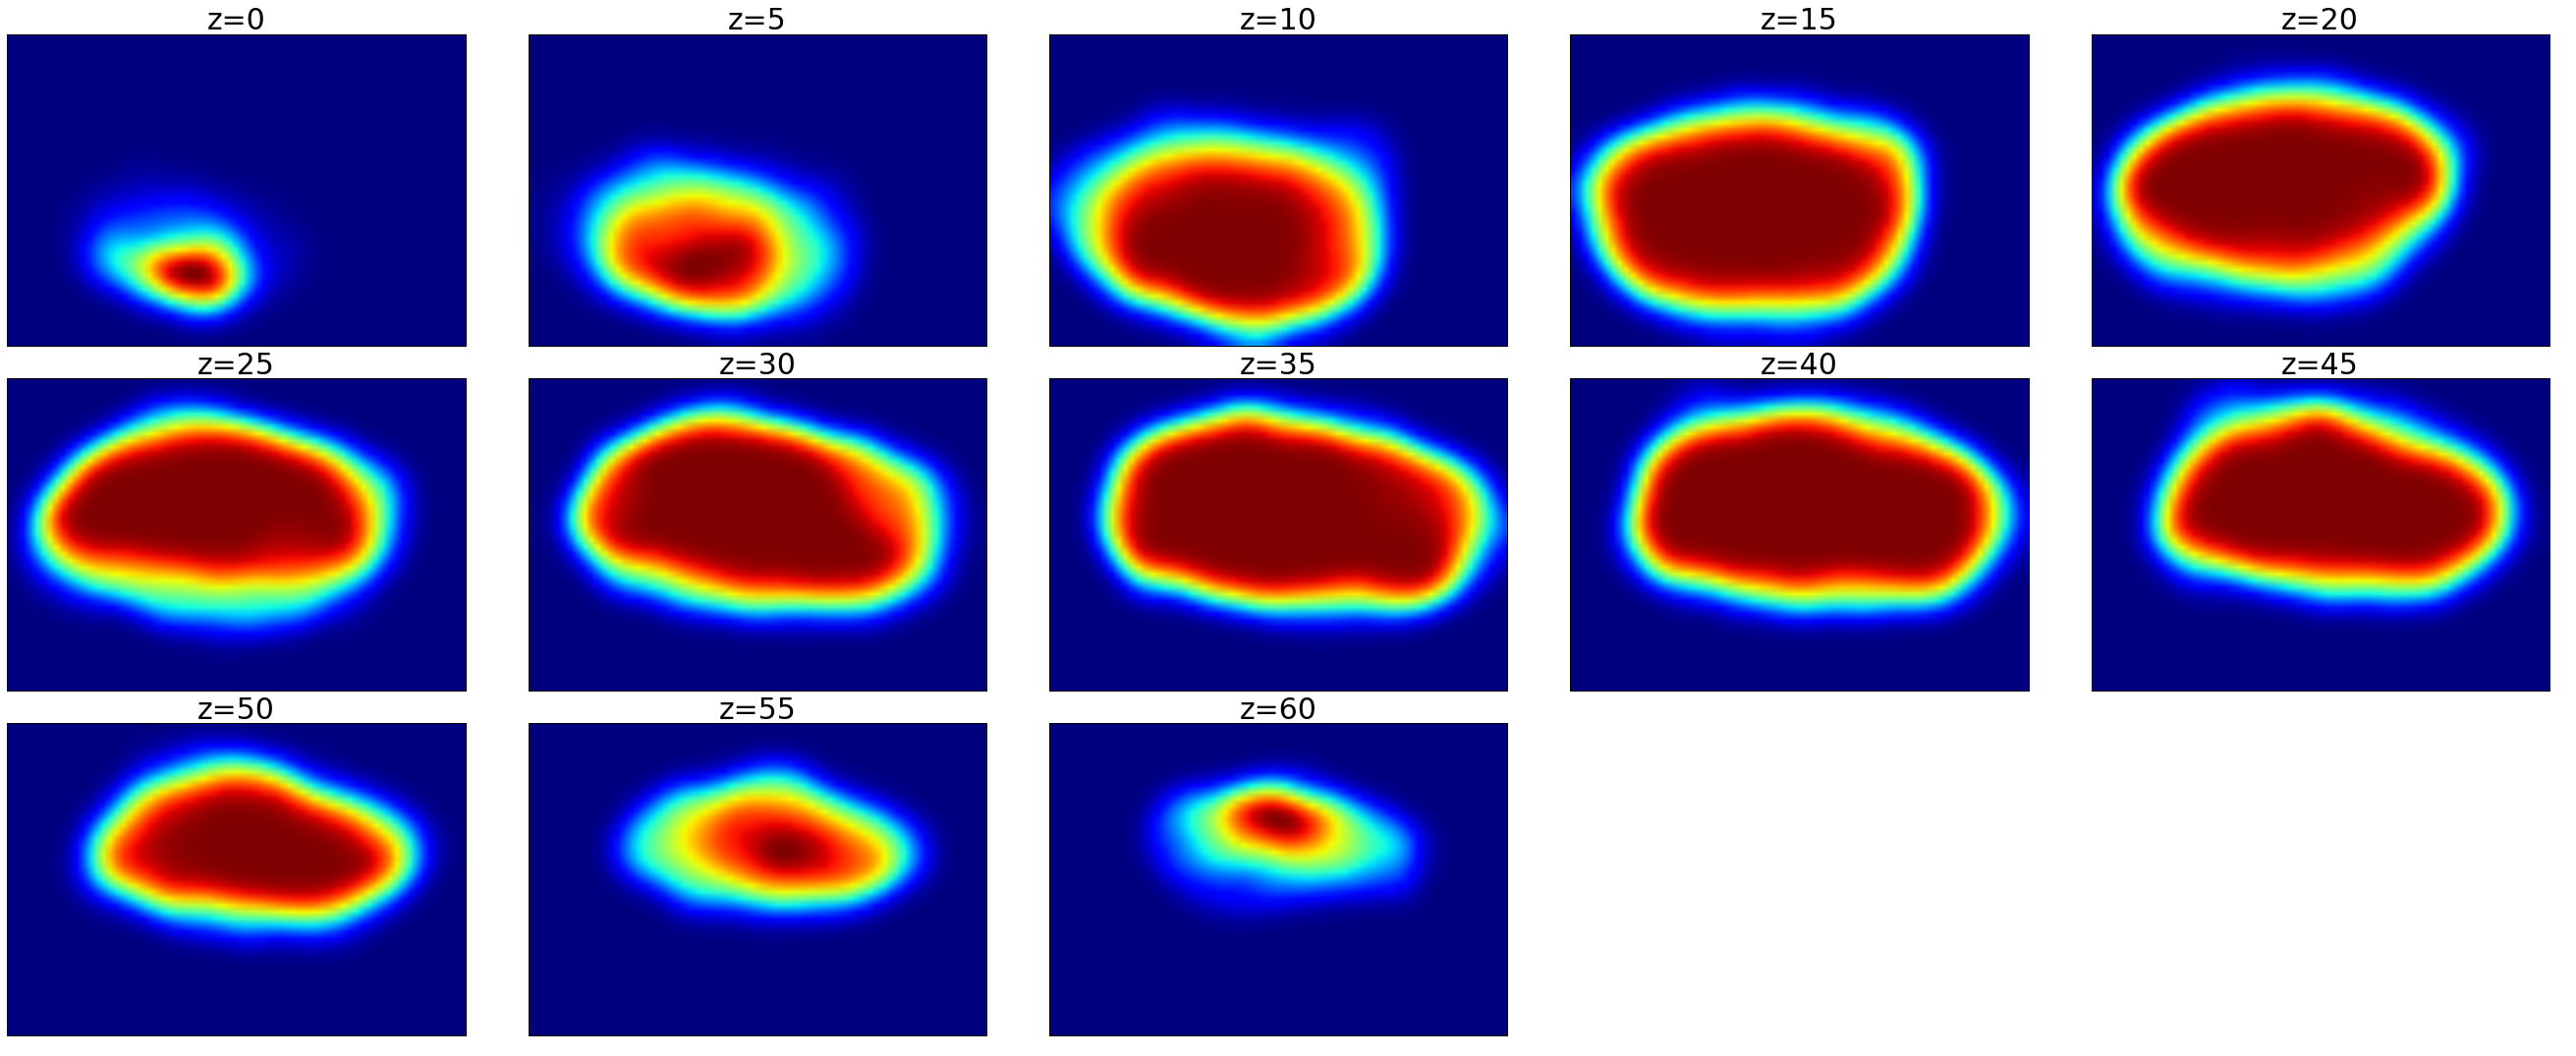

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [26]:
sided_name = '7N_L'

cur.execute("SELECT * FROM atlasV5 WHERE StructureName = '%(sided_name)s'" % {'sided_name': sided_name})

rows = cur.fetchall()
assert len(rows) == 1
row = rows[0]

shape = bp.unpack_ndarray_str(row['Shape'])
display_volume_sections(shape)

clf_w = bp.unpack_ndarray_str(row['ClassifierWeightVector'])
clf_b = row['ClassifierIntercept']

clf = LogisticRegression()
clf.coef_ = np.array([clf_w])
clf.intercept_  = np.array([clf_b])
clf.classes_ = np.array([-1., 1.])
print clf.predict(np.random.random((10, 1024)))

In [6]:
cur.execute("UPDATE Writers SET Name = %s WHERE Id = %s", 
    ("Guy de Maupasant", "4"))        

1L

In [7]:
cur.execute("SELECT * FROM Writers")

for i in range(cur.rowcount):

    row = cur.fetchone()
    print row

{'Id': 1L, 'Name': 'Jack London'}
{'Id': 2L, 'Name': 'Honore de Balzac'}
{'Id': 3L, 'Name': 'Lion Feuchtwanger'}
{'Id': 4L, 'Name': 'Guy de Maupasant'}
{'Id': 5L, 'Name': 'Truman Capote'}


In [38]:
if db:
    db.close()